# Feature Engineering to Reproduce Statistical Analyses 

In a complex and messy world where we can only observe so much through data, data cleaning and feature engineering are key steps in the data science pipeline to ensure predictive and generalizable models. Feature engineering allows us to imbue our dataset with context and structural information that can be invaluable. Practioners, Kaggle competition winners, and researchers all depend on good feature engineering for succesful machine learning pipelines.

A good general overview on the topic is available here: http://www.feat.engineering/

In this notebook we'll roughly reimplement the cleaning and analysis done in an economic paper on police auditing. This is an example of a simple and useful analysis that you could do with public data today and the tools you're currently learning in this class.

### Re-engineering the feature set and analysis of Goel et al 2016 "Precinct  Or  Prejudice?  Understanding  Racial Disparities  In  New  York  City’s  Stop-and-frisk  Policy"
https://5harad.com/papers/stop-and-frisk.pdf


New York's “Stop-and-Frisk” policy was eventually stopped for facilitating unconstitutional searches. Until that point, however, the police stopped and searched as many as 685,000 people per year. The vast majority of these stops were on Black and Hispanic people, who were 5 times less likely to actually have a weapon compared to their white counterparts. In this paper, the authors consider how many stops had nearly a 0% chance of producing a weapon based on features observed before the stop. 

In [1]:
# reminder: you can install packages (eg, sklearn) with 
!pip install sklearn

In [45]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.metrics import plot_roc_curve, recall_score, precision_score, roc_curve, roc_auc_score, balanced_accuracy_score
import matplotlib.pyplot as plt
import matplotlib as mpl

Some useful metrics for evaluating how good a classifier is:

Recall is 
avg(model predicts class = i | class=i)

Balanced accuracy is 
avg(recall)

In [3]:
# Downloading WILDS benchmark release https://wilds.stanford.edu/
! wget -nc https://worksheets.codalab.org/rest/bundles/0xea27fd7daef642d2aa95b02f1e3ac404/contents/blob/sqf.csv
# If the above command doesn't work, you can get the file by visiting the link in your browser

--2021-09-27 17:24:41--  https://worksheets.codalab.org/rest/bundles/0xea27fd7daef642d2aa95b02f1e3ac404/contents/blob/sqf.csv
Resolving worksheets.codalab.org (worksheets.codalab.org)... 13.68.212.115
Connecting to worksheets.codalab.org (worksheets.codalab.org)|13.68.212.115|:443... connected.
HTTP request sent, awaiting response... 200 OK
Syntax error in Set-Cookie: codalab_session=""; expires=Thu, 01 Jan 1970 00:00:00 GMT; Max-Age=-1; Path=/ at position 70.
Length: unspecified [text/csv]
Saving to: ‘sqf.csv’

sqf.csv                 [ <=>                ] 340.14M  48.5MB/s    in 7.0s    

2021-09-27 17:24:48 (48.6 MB/s) - ‘sqf.csv’ saved [356662697]



In [4]:
# Load the data
data_df = pd.read_csv('sqf.csv')

#### Before we dive into the analysis we need to narrow the scope of stops and demographic attributes that we're interested in

In [5]:
# The dataset contains all types of police interactions.
# Here we're narrowing it down to fraught practices related New York's controversial stop and frisk policies
data_df = data_df[data_df['suspected.crime'] == 'cpw']
data_df.head()

,Unnamed: 0,year,date,time,precinct,xcoord,ycoord,serial,radio.run,inside.outside,location.housing,observation.period,suspected.crime,stop.length,identification,reason.explained,others.stopped,arrested,arrested.reason,summons.issued,officer.uniform,officer.verbal,officer.shield,frisked,searched,extra.reports,force.hands,force.wall,force.ground,force.drawn,force.pointed,force.baton,force.handcuffs,force.pepper,force.other,stopped.bc.object,stopped.bc.desc,stopped.bc.casing,stopped.bc.lookout,stopped.bc.clothing,...,frisked.bc.furtive,frisked.bc.bulge,additional.report,additional.investigation,additional.proximity,additional.evasive,additional.associating,additional.direction,additional.highcrime,additional.time,additional.sights,additional.other,searched.hardobject,searched.outline,searched.admission,searched.other,found.contraband,found.pistol,found.rifle,found.assault,found.knife,found.machinegun,found.other,suspect.sex,suspect.race,suspect.hispanic,suspect.age,suspect.dob,suspect.height,suspect.weight,suspect.hair,suspect.eye,suspect.build,found.gun,found.weapon,id,lat,lon,borough,train.period
0,1505794,2009,2009-01-24,23:40,46.0,NaN,NaN,671.0,False,False,neither,1.0,cpw,1.0,photo,True,False,False,NaN,False,True,NaN,NaN,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,male,black,False,22,1987-10-25,6.000000,150.0,black,brown,medium,False,False,1518893,NaN,NaN,Bronx,True
1,1505796,2009,2009-01-30,19:30,47.0,1022722.0,262502.0,884.0,False,False,neither,1.0,cpw,1.0,verbal,True,False,False,NaN,False,False,NaN,True,True,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,...,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,male,black,False,20,NaN,6.000000,190.0,black,brown,medium,False,False,1518895,40.887097,-73.860862,Bronx,True
2,1505803,2009,2009-02-27,19:40,32.0,1000496.0,234145.0,1790.0,False,False,neither,1.0,cpw,2.0,photo,True,False,False,NaN,False,False,NaN,True,True,False,False,False,False,False,False,False,False,False,False,False,False,True,False,True,False,...,True,False,True,False,False,False,True,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,male,black,False,20,NaN,5.500000,130.0,black,brown,thin,False,False,1518902,40.809335,-73.941313,Manhattan,True
3,1505804,2009,2009-03-04,19:50,45.0,1011144.0,251424.0,825.0,False,False,neither,1.0,cpw,5.0,photo,True,False,False,NaN,False,True,NaN,NaN,True,False,False,True,False,False,False,False,False,False,False,False,False,True,True,False,False,...,True,False,False,False,False,False,False,False,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,male,black hispanic,True,40,1963-04-10,6.000000,200.0,brown,brown,medium,False,False,1518903,40.856735,-73.902779,Bronx,True
4,1505806,2009,2009-03-07,19:27,46.0,1009179.0,249328.0,2061.0,False,False,neither,2.0,cpw,1.0,photo,True,False,False,NaN,False,False,NaN,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,...,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,male,white hispanic,True,29,1980-03-29,5.583333,185.0,black,brown,medium,False,False,1518905,40.850988,-73.909891,Bronx,True


In [6]:
# Would it make sense to just drop samples with missing data?
print(f"Out of {data_df.shape[0]} total points, if we drop all with missing data \
we'll have {data_df.dropna().shape[0]} points ( or {data_df.dropna().shape[0]/data_df.shape[0]}\
of the original dataset")

Out of 621696 total points, if we drop all with missing data we'll have 8156 points ( or 0.013118952028000824of the original dataset


Poll: is dropping missing values a good idea for this dataset?
    * A) yes 
    * B) no

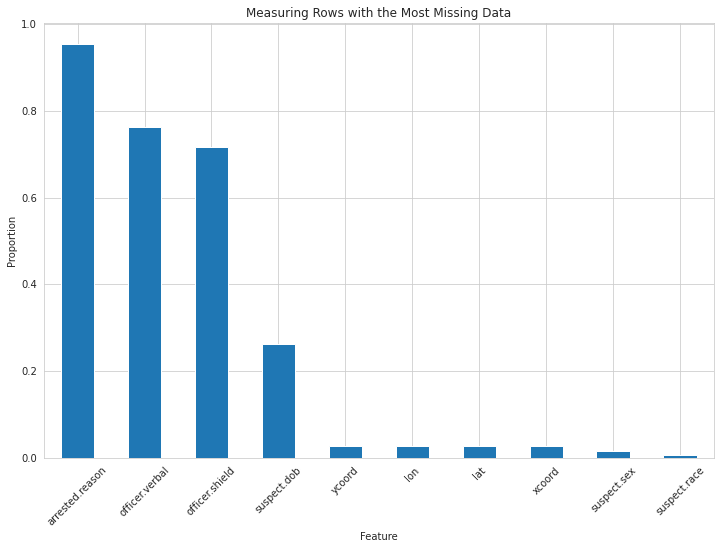

In [7]:
# What's missing?
sns.set_style('whitegrid')
plt.figure(figsize=(12,8))
missing_vals = data_df.isna().sum()/data_df.shape[0]
missing_vals = missing_vals.sort_values(ascending=False)[0:10]
ax = missing_vals.plot(kind='bar')

ax.set_title('Measuring Rows with the Most Missing Data')
ax.set_ylabel('Proportion')
ax.set_xlabel('Feature')
ax.tick_params(axis='x', rotation=45)

There are a mix of data types that are missing. Will this affect our analysis? Are the data missing in systematic ways?

*   Does it make sense that some of these are missing? 'arrested.reason' might, so long as most people aren't arrested. 
*  Suspect race and sex might be more problematic for our analysis, but most of the values are there
* What do officer.verbal and officer.shield represent? For now we'll exclude them, but how could we find out?
* xcoord and ycoord are real valued inputs. Should we include them as inputs to our model?


In [8]:
# What proportion of stops are arrests?
print(data_df.arrested.sum()/data_df.shape[0], " stops were arrests")

# What proportion of arrest reasons are we missing?
print(1- data_df['arrested.reason'].isna().sum()/data_df.shape[0],
      " have arrest reasons")

0.04613669703520692  stops were arrests
0.04610935248095527  have arrest reasons


We're going to remove racial categories with missing data or labels that the original paper doesn't consider. It seems like there are few enough points this should be OK, but we will need to highlight this in our final report.

In [9]:
# Following up on past work, the Goel paper chooses to only include black, hispanic, and white labels
categories = ['black', 'white hispanic', 'black hispanic', 'hispanic', 'white']
data_df = data_df.loc[data_df['suspect.race'].map(lambda x: x in categories)]
# Standardize capitalization
data_df['suspect.race'] = data_df['suspect.race'].map(lambda x: 'Hispanic' if 'hispanic' in x else x.title())

In [10]:
set(data_df['suspect.race'])

{'Black', 'Hispanic', 'White'}

In [11]:
feats_to_use = []

feats_to_use += ['suspect.height', 'suspect.weight', 'suspect.age', 'observation.period',
                        'inside.outside', 'location.housing', 'radio.run', 'officer.uniform']
# Primary stop reasoning features
feats_to_use += [i for i in data_df.columns if 'stopped.bc' in i]
# Secondary stop reasoning features, if any
feats_to_use += [i for i in data_df.columns if 'additional' in i]
feats_to_use

['suspect.height',
 'suspect.weight',
 'suspect.age',
 'observation.period',
 'inside.outside',
 'location.housing',
 'radio.run',
 'officer.uniform',
 'stopped.bc.object',
 'stopped.bc.desc',
 'stopped.bc.casing',
 'stopped.bc.lookout',
 'stopped.bc.clothing',
 'stopped.bc.drugs',
 'stopped.bc.furtive',
 'stopped.bc.violent',
 'stopped.bc.bulge',
 'stopped.bc.other',
 'additional.report',
 'additional.investigation',
 'additional.proximity',
 'additional.evasive',
 'additional.associating',
 'additional.direction',
 'additional.highcrime',
 'additional.time',
 'additional.sights',
 'additional.other']

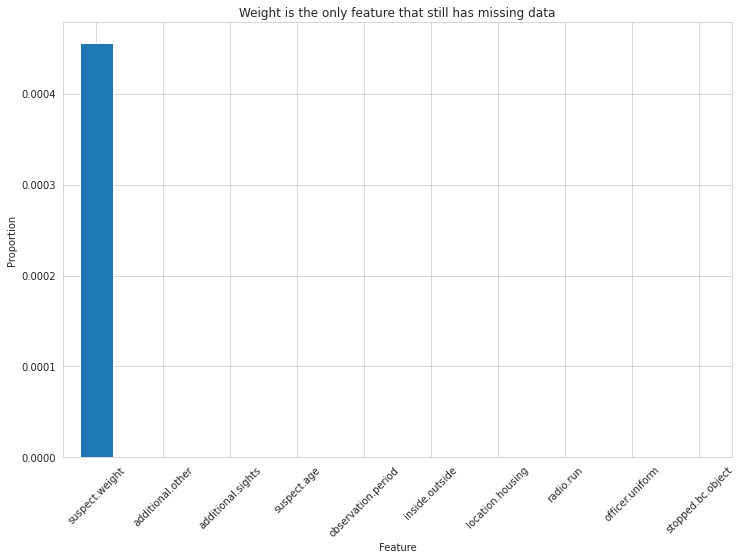

In [12]:
# What's still missing?
sns.set_style('whitegrid')
plt.figure(figsize=(12,8))
missing_vals = data_df[feats_to_use].isna().sum()/data_df.shape[0]
missing_vals = missing_vals.sort_values(ascending=False)[0:10]
ax = missing_vals.plot(kind='bar')

ax.set_title('Weight is the only feature that still has missing data')
ax.set_ylabel('Proportion')
ax.set_xlabel('Feature')
ax.tick_params(axis='x', rotation=45)

In [13]:
# very little data is still missing; let's drop missing rows 
data_df = data_df.dropna(subset = feats_to_use)

In [14]:
# To match the paper, lets only train on 2010 and earlier
train_df = data_df[data_df.year <= 2010].copy()

In [15]:
# # Build validation set
# def subsample_idxs(idxs, proportion, seed=4171):
#   """Split a dataframe into two with training size proportion*len(idxs). Seed lets
#   us get the same splits consistently"""
#   rng = np.random.default_rng(seed)
#   shuffled_idxs = idxs.copy()
#   rng.shuffle(shuffled_idxs)
#   train_size = int(proportion*len(shuffled_idxs))
#   return idxs[:train_size], idxs[train_size:]

# train_idxs, validation_idxs = subsample_idxs(train_df.index.tolist(), 0.8)

# val_df = train_df[train_df.index.isin(validation_idxs)]
# train_df = train_df[~train_df.index.isin(val_df.index)]


<class 'numpy.float64'>


Text(0.5, 0, 'Height (units?)')

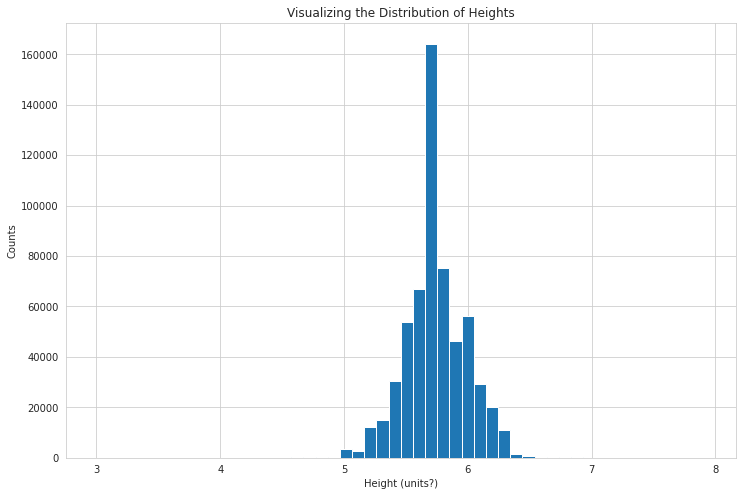

In [16]:
# Checks on data types? 
print(type(data_df['suspect.height'][0]))
ax = data_df['suspect.height'].hist(figsize=(12,8), bins=50)
ax.set_title('Visualizing the Distribution of Heights')
ax.set_ylabel('Counts')
ax.set_xlabel('Height (units?)')

<class 'str'>


Text(0, 0.5, 'Counts')

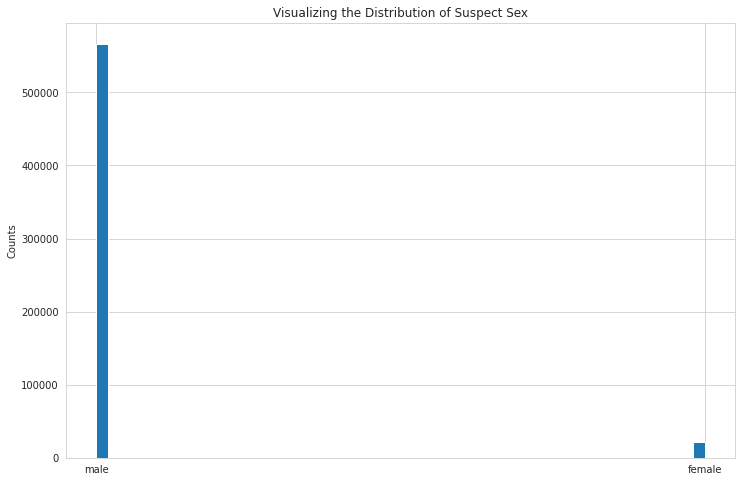

In [17]:
# Checks on data types? 
print(type(data_df['suspect.sex'][0]))
ax = data_df['suspect.sex'].hist(figsize=(12,8), bins=50)
ax.set_title('Visualizing the Distribution of Suspect Sex')
ax.set_ylabel('Counts')

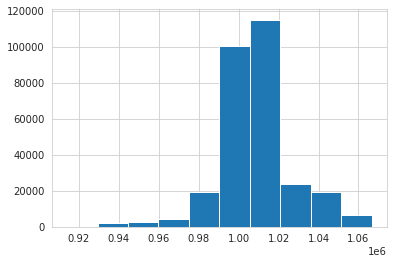

In [18]:
# What about location data?
train_df.xcoord.hist()

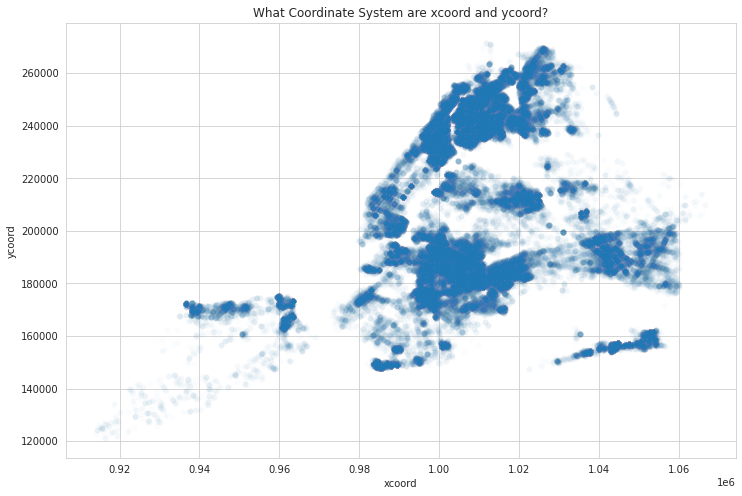

In [19]:
# How to encode location? Latititude and longitude?
sns.set_style('whitegrid')
plt.figure(figsize=(12,8))
ax = sns.scatterplot(x='xcoord', y='ycoord', data=train_df, alpha=0.02)

ax.set_title('What Coordinate System are xcoord and ycoord?')
ax.set_ylabel('ycoord')
ax.set_xlabel('xcoord')
ax.tick_params(axis='x', rotation=0)

In [20]:
# From NYPD documents.
inverted_bor_dict = {'Manhattan' :
[1,5,6,7,9,10,13,17,19,20,23,24,25,26,28,30,32,33,34,14,18,22],
'Bronx':
[40,41,42,43,44,45,46,47,48,49,50,52],
'Brooklyn':
[60,61,62,63,66,67,68,69,70,71,72,73,75,76,77,78,79,81,83,84,88,90,94],
'Queens':
[100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115],
'Staten Island':
[120,121,122,123]}

bor_dict = {}
for k,v in inverted_bor_dict.items():
    for i in v:
        bor_dict[i]= k

train_df['borough'] = train_df.precinct.map(bor_dict)

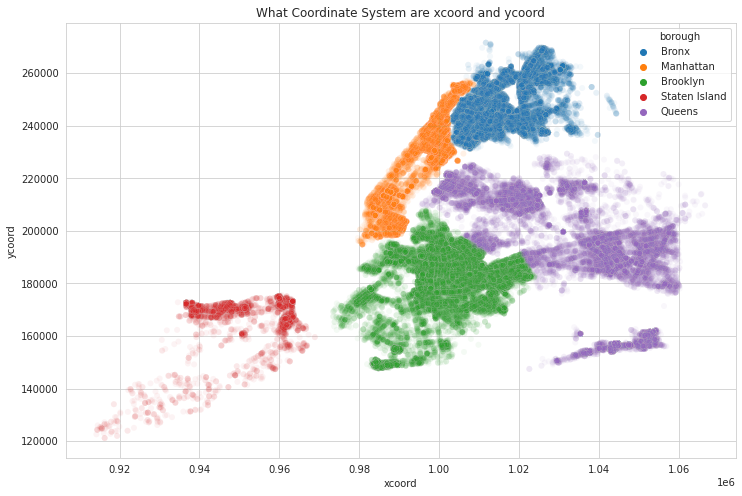

In [21]:
# Plot boroughs
sns.set_style('whitegrid')
plt.figure(figsize=(12,8))
ax = sns.scatterplot(x='xcoord', y='ycoord', data=train_df, alpha=0.05, hue='borough')
ax.set_title('What Coordinate System are xcoord and ycoord')
ax.set_ylabel('ycoord')
ax.set_xlabel('xcoord')
ax.tick_params(axis='x', rotation=0)

In [22]:
feats_to_use += ['borough']

In [23]:
train_df[feats_to_use].head(3)

,suspect.height,suspect.weight,suspect.age,observation.period,inside.outside,location.housing,radio.run,officer.uniform,stopped.bc.object,stopped.bc.desc,stopped.bc.casing,stopped.bc.lookout,stopped.bc.clothing,stopped.bc.drugs,stopped.bc.furtive,stopped.bc.violent,stopped.bc.bulge,stopped.bc.other,additional.report,additional.investigation,additional.proximity,additional.evasive,additional.associating,additional.direction,additional.highcrime,additional.time,additional.sights,additional.other,borough
0,6.0,150.0,22,1.0,False,neither,False,True,False,False,False,False,False,False,True,True,False,False,False,False,False,False,False,False,False,False,False,False,Bronx
1,6.0,190.0,20,1.0,False,neither,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,Bronx
2,5.5,130.0,20,1.0,False,neither,False,False,False,True,False,True,False,False,True,False,False,False,True,False,False,False,True,False,False,True,False,False,Manhattan


# SGD and normalization
To get results quickly on a dataset this size, let's SGD to fit our model. A good rule of thumb is to normalize or standardize your data when using SGD.
Normalization ensures the same step size works well for all features, big or small.
SGD can converge faster on normalized data. 

In [24]:
# Normalize numeric features
columns_to_norm = ['suspect.height', 'suspect.weight', 'suspect.age', 'observation.period']
df_unnormed_train = train_df.copy()

def stand_columns(df, unnormed_train, columns_to_norm):
  """Standardizes features based on an unnormed training dataframe"""
  for feature_name in columns_to_norm:
                df[feature_name] = df[feature_name] - np.mean(unnormed_train[feature_name])
                df[feature_name] = df[feature_name] / np.std(unnormed_train[feature_name])
  return df

def norm_columns(df, unnormed_train, columns_to_norm):
  """Normalize features based on an unnormed training dataframe"""
  for feature_name in columns_to_norm:
                df[feature_name] = df[feature_name] - np.min(unnormed_train[feature_name])
                df[feature_name] = df[feature_name]/df[feature_name].max()
  return df

x_df = norm_columns(train_df.copy(), df_unnormed_train, columns_to_norm)


In [25]:
x_df[feats_to_use].head(10)

,suspect.height,suspect.weight,suspect.age,observation.period,inside.outside,location.housing,radio.run,officer.uniform,stopped.bc.object,stopped.bc.desc,stopped.bc.casing,stopped.bc.lookout,stopped.bc.clothing,stopped.bc.drugs,stopped.bc.furtive,stopped.bc.violent,stopped.bc.bulge,stopped.bc.other,additional.report,additional.investigation,additional.proximity,additional.evasive,additional.associating,additional.direction,additional.highcrime,additional.time,additional.sights,additional.other,borough
0,0.610169,0.163399,0.171429,0.001001,False,neither,False,True,False,False,False,False,False,False,True,True,False,False,False,False,False,False,False,False,False,False,False,False,Bronx
1,0.610169,0.206972,0.142857,0.001001,False,neither,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,Bronx
2,0.508475,0.141612,0.142857,0.001001,False,neither,False,False,False,True,False,True,False,False,True,False,False,False,True,False,False,False,True,False,False,True,False,False,Manhattan
3,0.610169,0.217865,0.428571,0.001001,False,neither,False,True,False,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,True,True,False,False,Bronx
4,0.525424,0.201525,0.271429,0.002002,False,neither,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,Bronx
5,0.559322,0.141612,0.157143,0.001001,False,neither,False,False,False,False,False,False,False,False,True,False,True,False,False,True,False,True,False,True,True,False,False,False,Brooklyn
6,0.508475,0.174292,0.071429,0.002002,False,neither,False,True,False,False,False,False,True,False,True,False,True,False,False,False,True,False,False,True,True,False,False,False,Bronx
7,0.559322,0.162309,0.042857,0.002002,False,neither,False,True,False,False,True,False,False,False,True,False,False,False,False,False,False,False,False,False,True,False,False,False,Bronx
8,0.627119,0.261438,0.300000,0.002002,False,neither,True,True,False,False,False,False,False,False,True,False,False,False,False,False,False,True,False,False,False,False,False,False,Manhattan
9,0.593220,0.228758,0.528571,0.005005,False,housing,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,True,True,False,False,Manhattan


In [26]:
# convert categorical features using one-hot encoding
# (here, only borough is categorical, 
# but pd.get_dummies figures that out automatically!)
dummy_feats = feats_to_use + ['found.weapon']
x_df = pd.get_dummies(x_df[dummy_feats])
new_feats = x_df.columns

What do our dummy features look like?

In [27]:
print('before')
train_df['borough'].head(5)

before


0        Bronx
1        Bronx
2    Manhattan
3        Bronx
4        Bronx
Name: borough, dtype: object

In [28]:
print('after')
x_df[new_feats].head(5)[new_feats[-5:]]

after


,borough_Bronx,borough_Brooklyn,borough_Manhattan,borough_Queens,borough_Staten Island
0,1,0,0,0,0
1,1,0,0,0,0
2,0,0,1,0,0
3,1,0,0,0,0
4,1,0,0,0,0


In [29]:
# exclude the label (found.weapon) from the set of training features
new_feats = [i for i in new_feats if i != 'found.weapon']

In [30]:
# PolynomialFeatures model is a simple way to 
# generate polynomial features
poly = PolynomialFeatures(1) # adds a bias feature
# construct a numpy array from our dataframe according to the poly model
x = poly.fit_transform(x_df[new_feats])
features = poly.get_feature_names(x_df.columns)
features[:5]

['1', 'suspect.height', 'suspect.weight', 'suspect.age', 'observation.period']

In [31]:
features[-5:]

['location.housing_transit',
 'borough_Bronx',
 'borough_Brooklyn',
 'borough_Manhattan',
 'borough_Queens']

In [32]:
x[:5, :5]

array([[1.        , 0.61016949, 0.16339869, 0.17142857, 0.001001  ],
       [1.        , 0.61016949, 0.20697168, 0.14285714, 0.001001  ],
       [1.        , 0.50847458, 0.1416122 , 0.14285714, 0.001001  ],
       [1.        , 0.61016949, 0.21786492, 0.42857143, 0.001001  ],
       [1.        , 0.52542373, 0.20152505, 0.27142857, 0.002002  ]])

In [33]:
# We're running SGD for the demo. 
# Other methods are too slow (>1min) for a live demo!
np.random.seed(0)
clf = SGDClassifier(fit_intercept=False, class_weight='balanced', loss='log', 
                         penalty='l2', verbose=False, max_iter=10000, warm_start=False)
clf.fit(x, x_df['found.weapon'])
print(clf.score(x, x_df['found.weapon']))

score = balanced_accuracy_score(x_df['found.weapon'], clf.predict(x))
print(score)

0.8731943594914946
0.7418180676524939


In [34]:
# Do higher level features help? 
# The original paper includes them, but let's double check
np.random.seed(0)
poly = PolynomialFeatures(2)
x = poly.fit_transform(x_df[new_feats])

# Fit model. This model has over 600 features, so it is nice that we're using SGD
clf2 = SGDClassifier(fit_intercept=False, class_weight='balanced', loss='log', 
                         penalty='l2', verbose=False, max_iter=10000, warm_start=False)
clf2.fit(x, x_df['found.weapon'])

SGDClassifier(alpha=0.0001, average=False, class_weight='balanced',
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=False,
              l1_ratio=0.15, learning_rate='optimal', loss='log',
              max_iter=10000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=None, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=False, warm_start=False)

In [35]:
score2 = balanced_accuracy_score(x_df['found.weapon'], clf2.predict(x))

print(f'The polynomial features improve balanced accuracy by {str((score2-score)/score*100)[0:4]}%!')

The polynomial features improve balanced accuracy by 2.51%!


# Validation
But wait! It doesn't make sense to apply the model to the same dataset it was trained on. We want to use it to make future predictions. How well will it work? Let's build a test set:

In [36]:
# Let's test our model on data that came after the training range
test_df =  data_df[data_df.year > 2010].copy()
test_df['borough'] = test_df.precinct.map(bor_dict)

# normalize columns of test df according to mean and std in training set
xt_df = norm_columns(test_df.copy(), df_unnormed_train, columns_to_norm)

# Let's save a copy of our full dataframe for later analysis
xt_backup = xt_df.copy() 

# convert categoricals (borough) to one-hot
xt_df = pd.get_dummies(xt_df[dummy_feats])
xt = xt_df[new_feats]

# identify labels
Y = xt_backup['found.weapon'].values

In [37]:
# Let's compare our base model
poly = PolynomialFeatures(1) # add bias column
xt = poly.fit_transform(xt)
preds = clf.predict(xt)
score = balanced_accuracy_score(Y, preds)
score

0.7398104356955675

Great, that's only slightly lower than the training set. 

In [38]:
poly = PolynomialFeatures(2)
x2 = poly.fit_transform(xt_df[new_feats])
preds = clf2.predict(x2)
score2 = balanced_accuracy_score(Y, preds)
print(f'On the test set, polynomial features improve balanced accuracy by {str((score2-score)/score*100)[0:4]}%')

On the test set, polynomial features improve balanced accuracy by 0.73%


# Advanced evaluation metrics (bonus)

In [39]:
def pred_at_20(clf, x):
  return clf.predict_proba(x)[:, 1] >= 0.80

# groupwise_performance
def get_group_feats(X, Y, backup_df, group):
  """Return numpy feature matrix and label array for selected group"""
  df = backup_df.copy()
  df.reset_index(inplace=True)
  df = df[df['suspect.race'] == group]
  idxs = df.index.values
  return X[idxs, :], Y[idxs]

results = {}
for group in ['White', 'Black', 'Hispanic']:
  x_group, y_group = get_group_feats(xt, Y, xt_backup, group)
  preds = pred_at_20(clf, x_group)
  perf = precision_score(y_group, preds)
  results[f"{group} New Yorkers"] = perf

In [40]:
results = pd.DataFrame(results.items(), columns = ['Group', 'Proportion of Weapon Searches Resulting in a Weapon'])


Text(0.5, 0.9, 'Even though this is the top quintile for likely pedestrians, Black and Hispanic New Yorkers \n are still much less likely to actually have a weapon.')

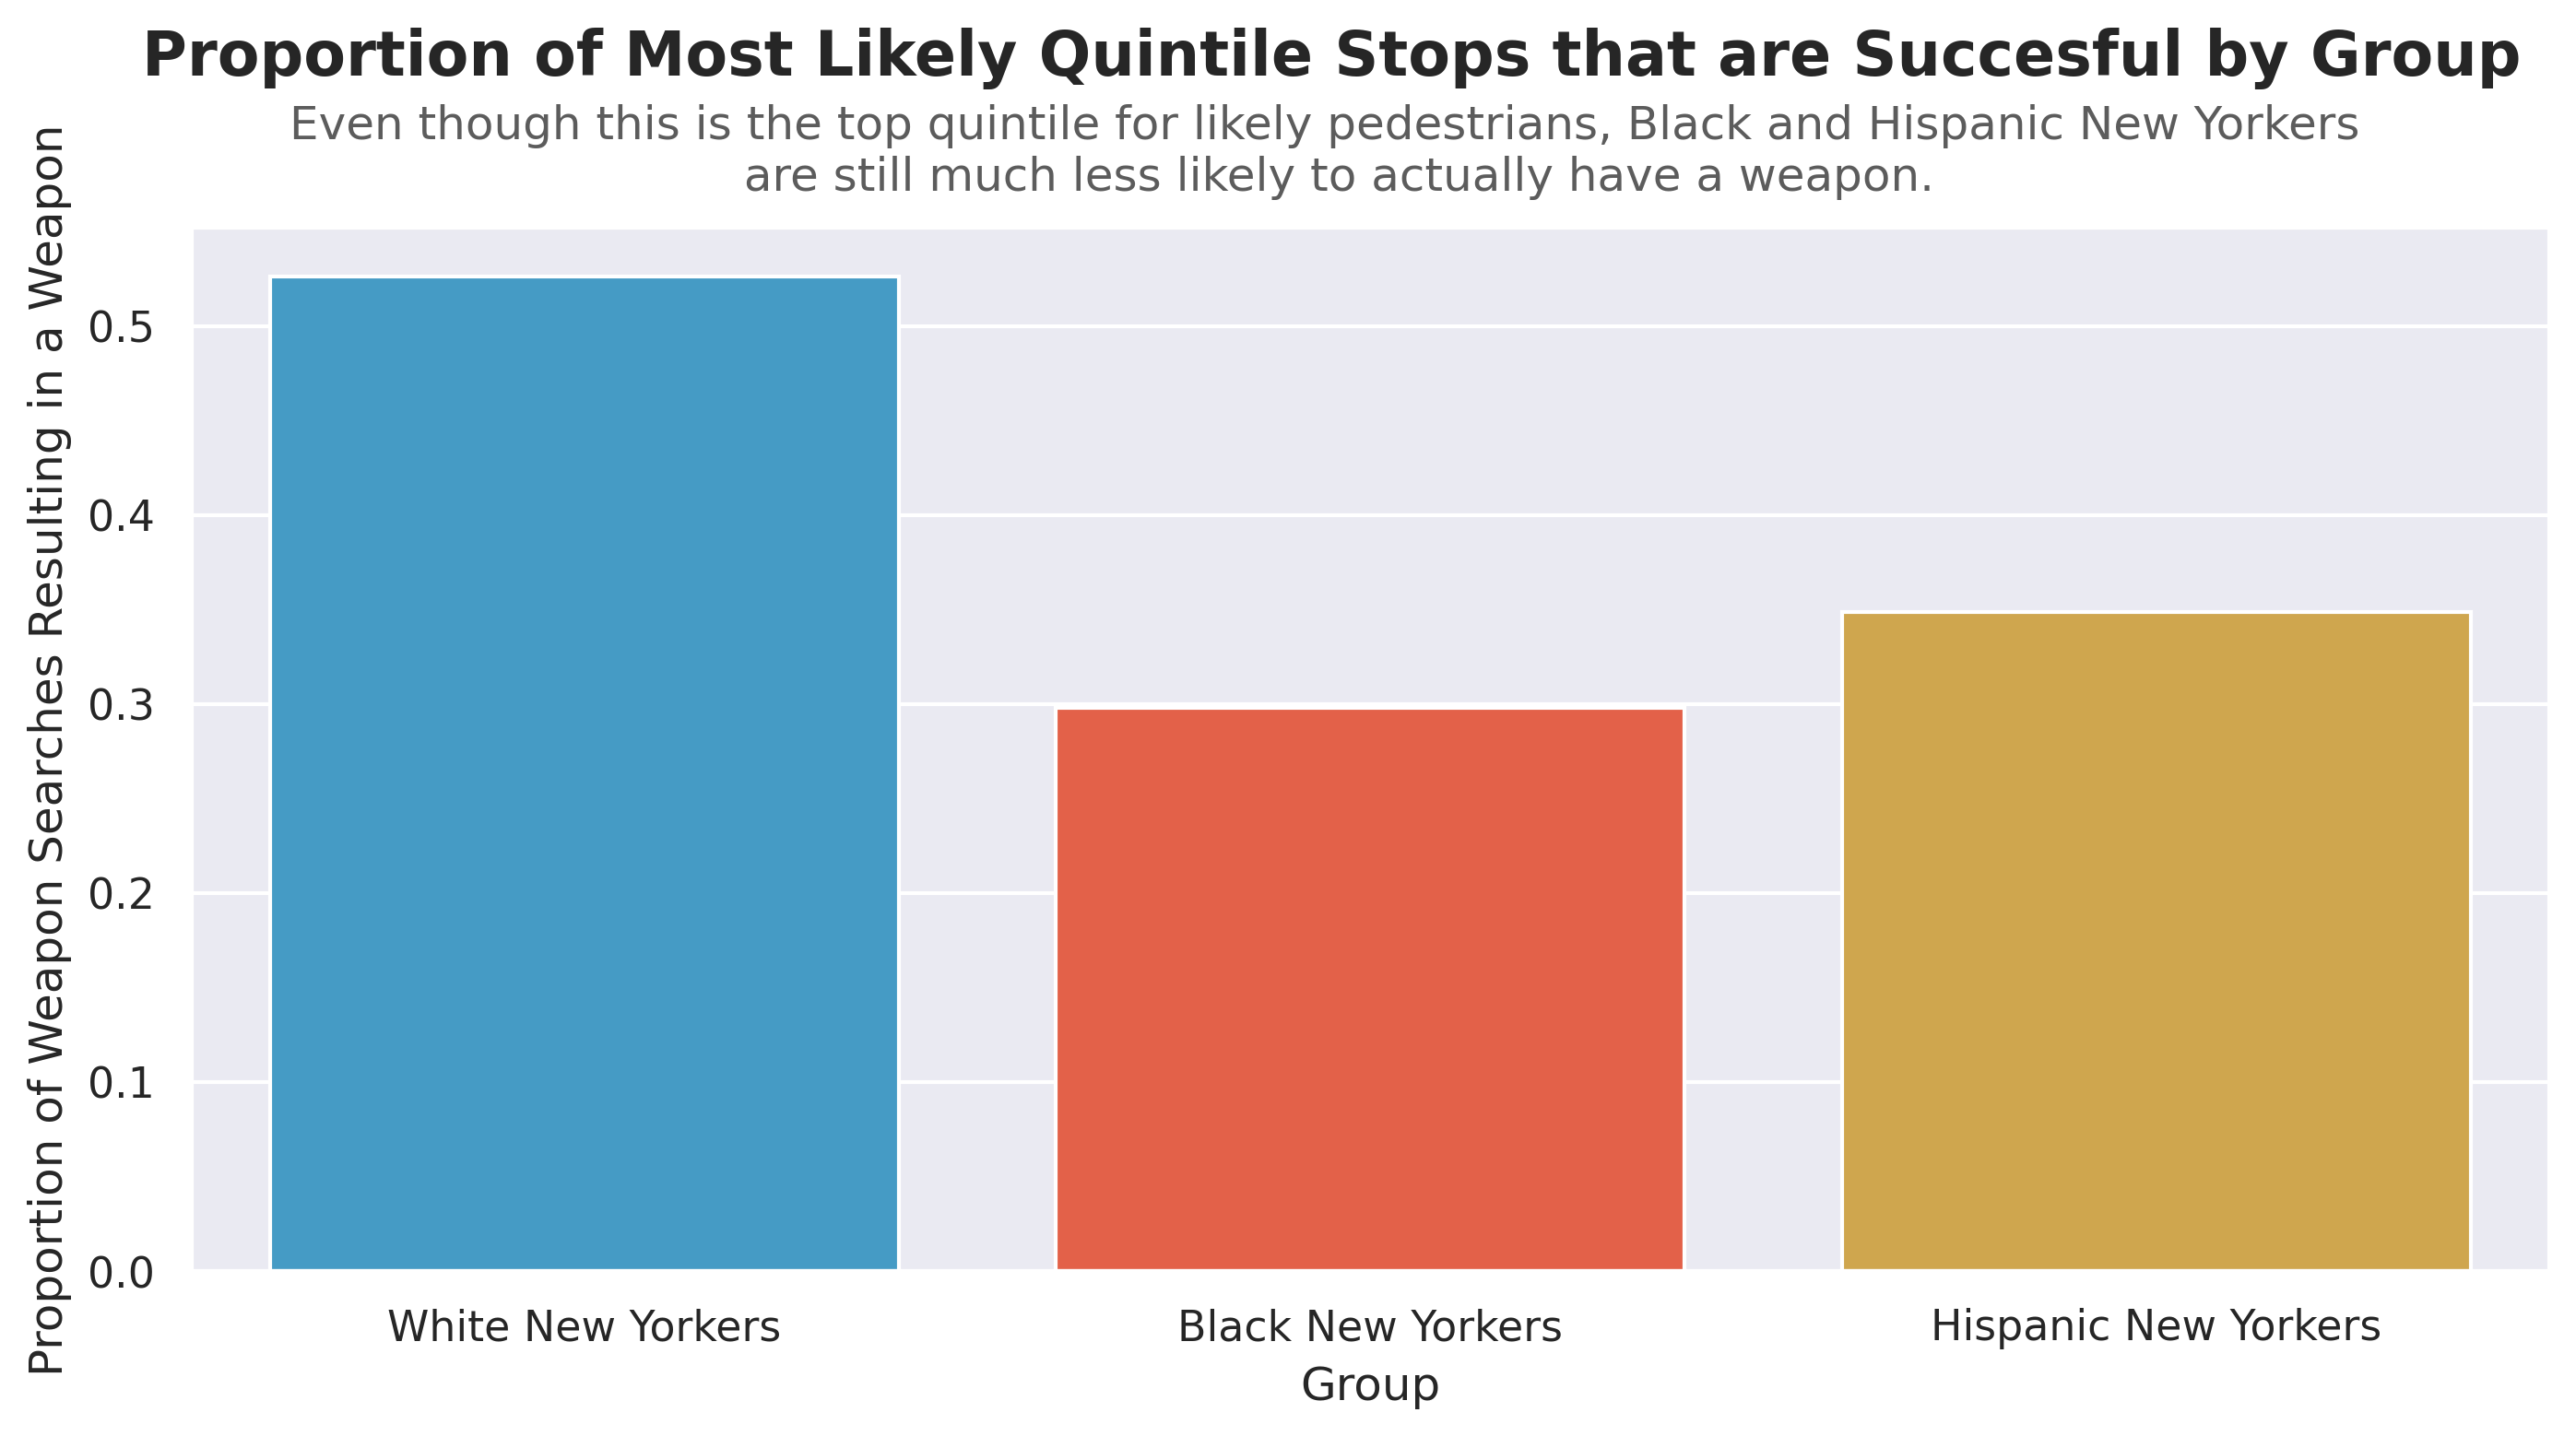

In [41]:
mpl.rcParams['figure.dpi'] = 300

scheme = [
    "#30a2da",
    "#fc4f30",
    "#e5ae38",
]

sns.set_palette(scheme) # https://gist.github.com/zachwill/d5190af1a7f455dea45d
sns.set(font_scale=1)
fig, ax = plt.subplots( figsize=(11, 5))
ax = sns.barplot(x='Group', y='Proportion of Weapon Searches Resulting in a Weapon',
                 data=results, ax = ax, palette = scheme)

ax.tick_params(axis='x', rotation=0)

fig.text(x=.5, y=.98, s='Proportion of Most Likely Quintile Stops that are Succesful by Group', fontsize=16, weight='bold', ha='center', va='bottom')
fig.text(x=.5, y=.90, alpha=0.75, s='Even though this is the top quintile for likely pedestrians, Black and Hispanic New Yorkers \n are still much less likely to actually have a weapon.', ha='center', fontsize=12, va='bottom')
            

In [42]:
# encoding missingness? 
# http://www.feat.engineering/encoding-missingness.html

In [43]:
# Uncomment for some bonus plotting! 
# def pred_at_z(clf, x, z):
#   """Predict at an arbitrary threshold"""
#   return clf.predict_proba(x)[:, 1] >= z

# # groupwise_performance
# def get_group_feats(X, Y, backup_df, group):
#   """Return numpy feature matrix and label array for selected group"""
#   df = backup_df.copy()
#   df.reset_index(inplace=True)
#   df = df[df['suspect.race'] == group]
#   idxs = df.index.values
#   return X[idxs, :], Y[idxs]

# Y = xt_backup['found.weapon'].values

# results = []
# for group in ['White', 'Black', 'Hispanic']:
#   x_group, y_group = get_group_feats(xt, Y, xt_backup, group)
#   preds = clf.predict_proba(x_group)[:, 1]
#   for i in np.linspace(0, 1, 100):
#     perf = precision_score(y_group, preds >= i)
#     results.append([f"{group} New Yorkers", perf, i])

# ax =sns.lineplot(data=pd.DataFrame(results, columns=['Group', 'Precision', 'Threshold']),
#              hue='Group', x= 'Threshold', y='Precision', palette = scheme)
# ax.invert_xaxis()

# Intro to kernels

Kernel functions provide a powerful way to lift our original problem space into higher (more seperable) dimensions. For the purposes of the kernel trick, a kernel function only need be symmetric and PSD. For a rigorous examination of kernel functions, your TAs recommend chapter 6 of Pattern Recognition and Machine Learning, Bishop (from course about page).



Inspiration and code snippets from https://www.eric-kim.net/eric-kim-net/posts/1/kernel_trick_blog_ekim_12_20_2017.pdf

Percentage of '0' labels: 0.5
Percentage of '1' labels: 0.5


LogisticRegression(C=1.0, class_weight='balanced', dual=False,
                   fit_intercept=False, intercept_scaling=1, l1_ratio=None,
                   max_iter=1000, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=False,
                   warm_start=False)

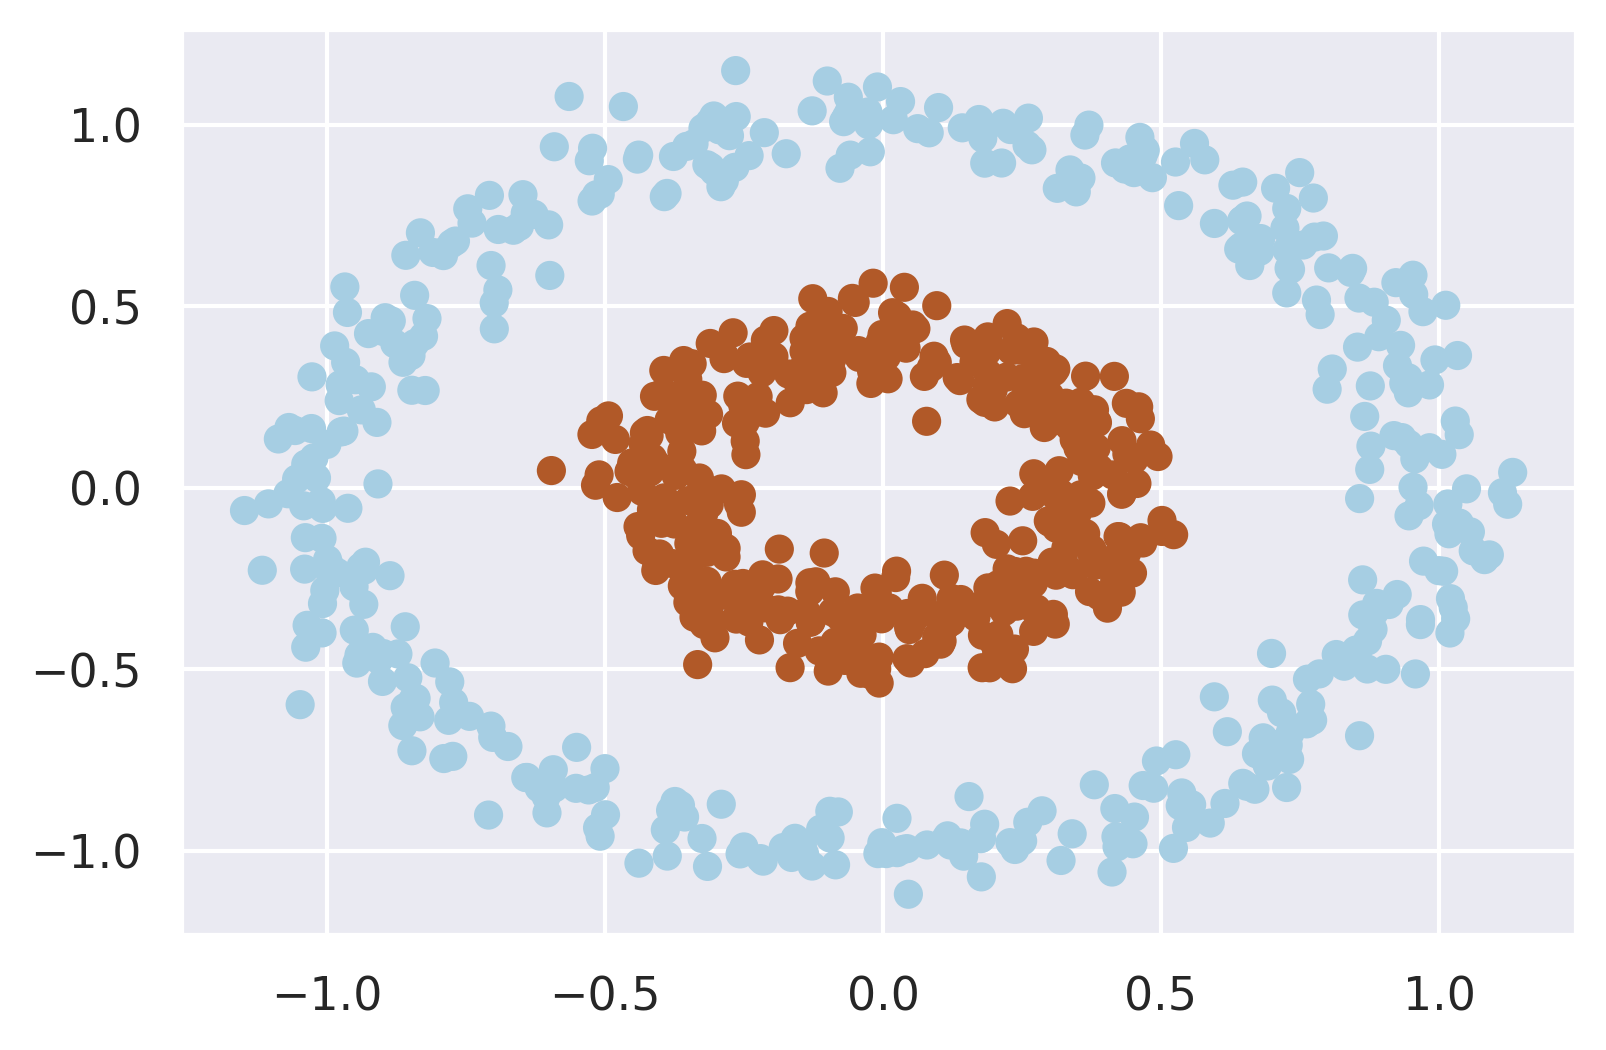

In [46]:
from sklearn.datasets import make_circles

X1, Y1 = make_circles(n_samples=800, noise=0.07, factor=0.4)
frac0 = len(np.where(Y1 == 0)[0]) / float(len(Y1))
frac1 = len(np.where(Y1 == 1)[0]) / float(len(Y1))

print("Percentage of '0' labels:", frac0)
print("Percentage of '1' labels:", frac1)

fig, ax = plt.subplots(figsize=(6,4))
plt.scatter(X1[:, 0], X1[:, 1], marker='o', c=Y1, cmap='Paired')
clf = LogisticRegression(fit_intercept=False, class_weight='balanced',
                         penalty='l2', verbose=False, max_iter=1000)
clf.fit(X1, Y1)


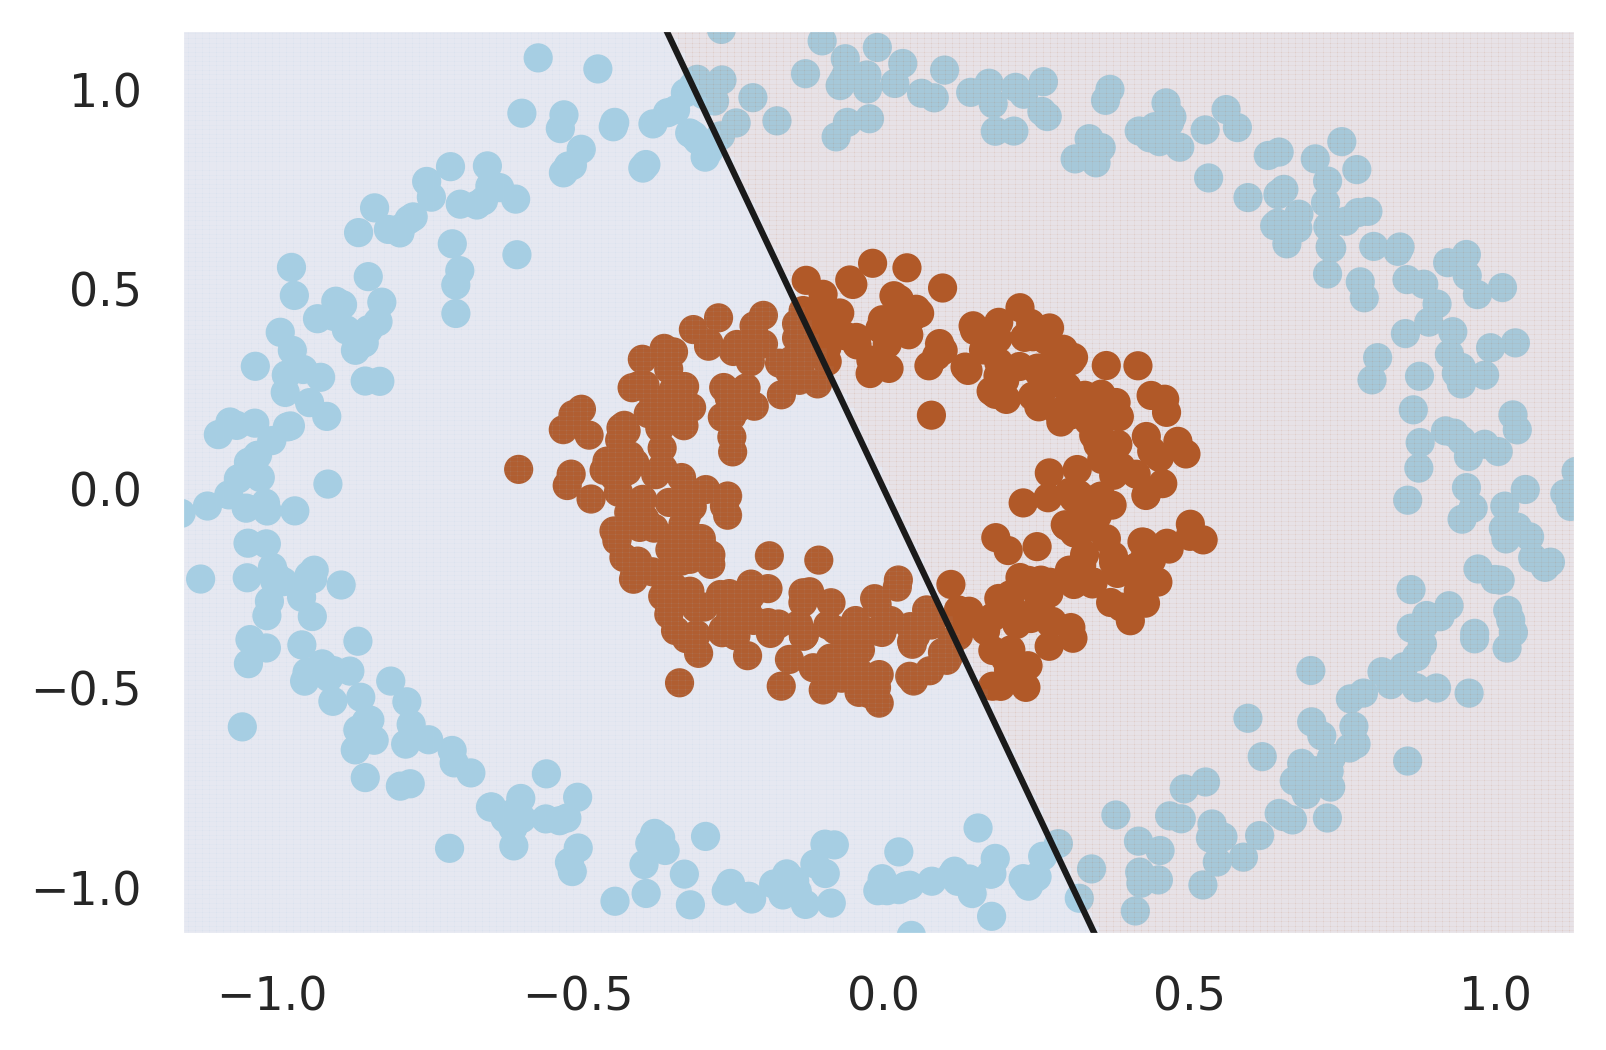

In [47]:
fig, ax = plt.subplots(figsize=(6,4))
plt.scatter(X1[:, 0], X1[:, 1], marker='o', c=Y1, cmap='Paired')

x_min = X1[:, 0].min()
x_max = X1[:, 0].max()
y_min = X1[:, 1].min()
y_max = X1[:, 1].max()
XX, YY = np.mgrid[x_min:x_max:200j, y_min:y_max:200j]
grid_coords = np.c_[XX.ravel(), YY.ravel()]
Z = clf.decision_function(grid_coords)


# Put the result into a color plot
Z = Z.reshape(XX.shape)
plt.pcolormesh(XX, YY, Z > 0, cmap=plt.cm.Paired, alpha=0.05)
plt.contour(XX, YY, Z, colors=['k', 'k', 'k'],
          linestyles=['--', '-', '--'],
          levels=[-.5, 0, .5], alpha=1)

In [48]:
def get_x1x2_feat(X):
  X = X.copy()
  new_col = (X[:, 0]**2+X[:, 1]**2).reshape(-1, 1)
  return np.append(X, new_col, axis=1) 

In [49]:
X2 = get_x1x2_feat(X1)

In [50]:
def r3_to_3r1(X,Y, label=1):
  """Pull apart columns of a matrix with width 3. Only keep rows with label"""
  X = X[np.where(Y == label)]
  return X[:, 0], X[:, 1], X[:, 2]

print(len(r3_to_3r1(X2, Y1)))
print(r3_to_3r1(X2, Y1)[0].shape)

3
(400,)


Text(0.5, 0.92, 'Data in R^3 (separable w/ hyperplane)')

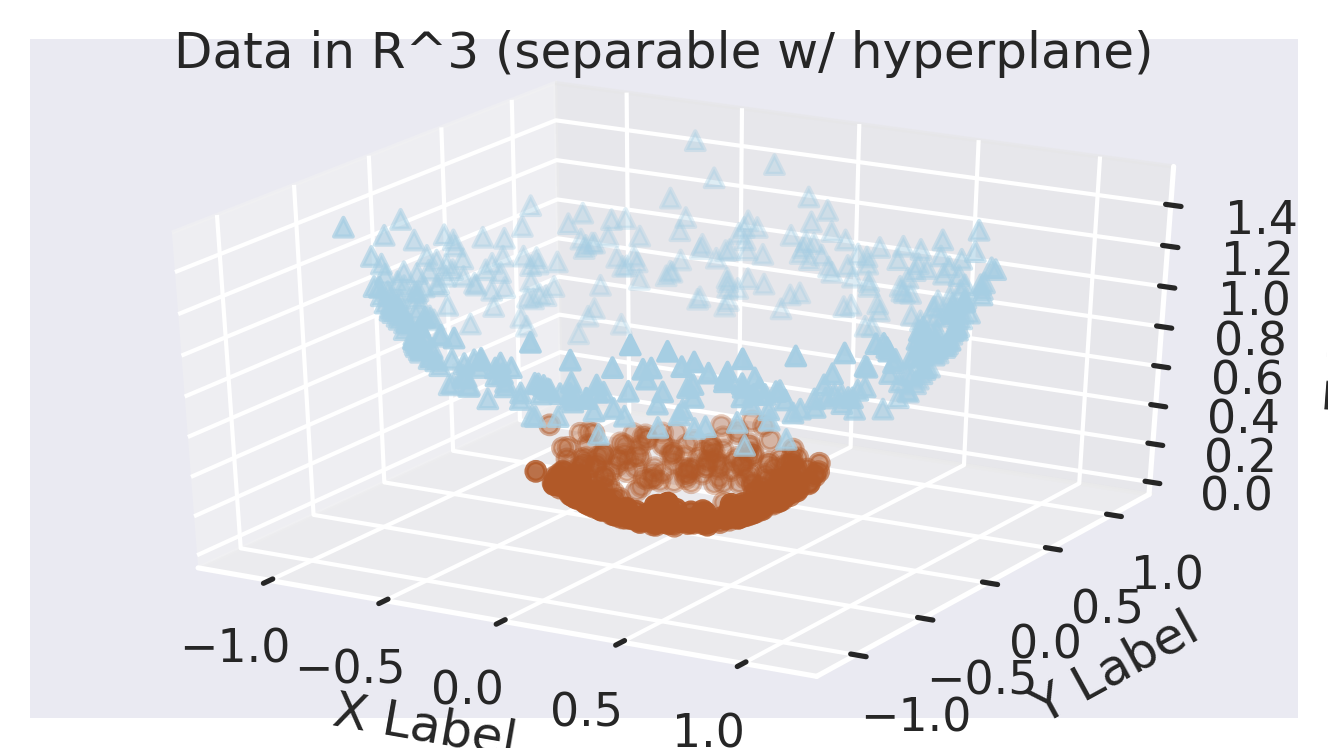

In [51]:
fig = plt.figure(figsize=(12,3))
ax = fig.add_subplot(121, projection='3d')

ax.scatter(*r3_to_3r1(X2, Y1), color=plt.cm.Paired(11), marker='o')
ax.scatter(*r3_to_3r1(X2, Y1, label=0), color=plt.cm.Paired(0), marker='^')

ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')
ax.set_title("Data in R^3 (separable w/ hyperplane)")

Text(0.5, 1.0, 'Linear Fit on Kernel Matrix Projected Back Down')

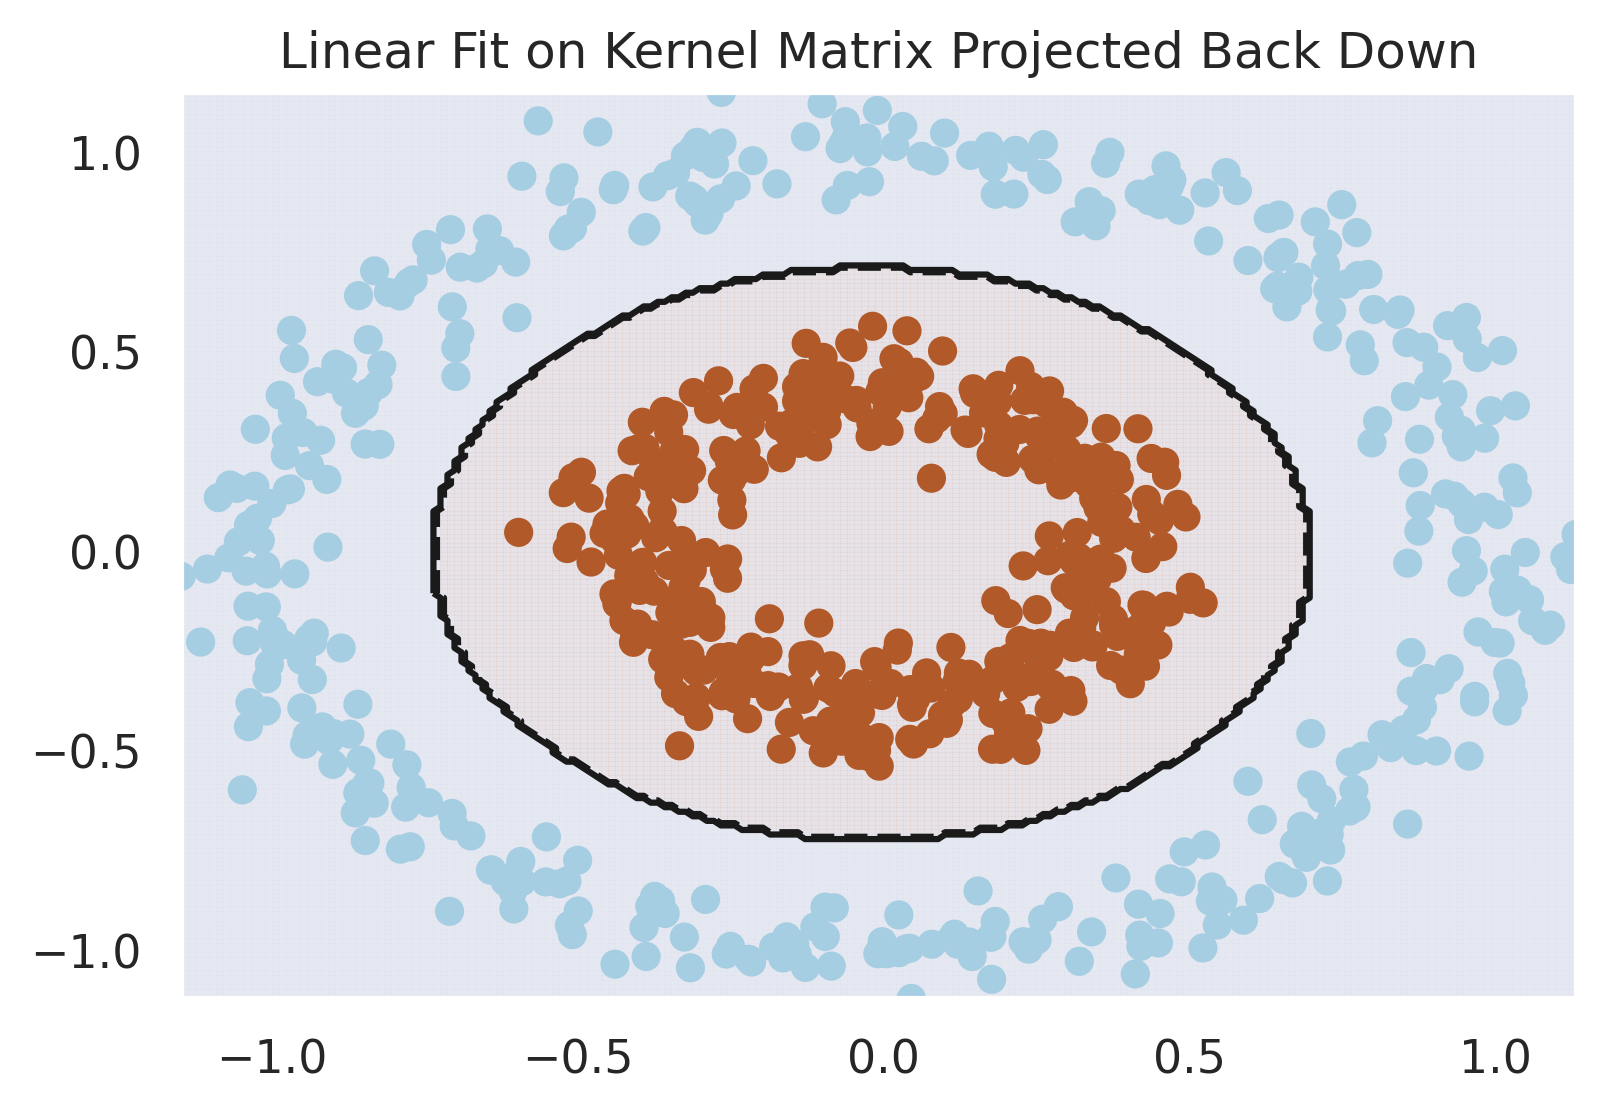

In [52]:
fig, ax = plt.subplots(figsize=(6,4))
plt.scatter(X1[:, 0], X1[:, 1], marker='o', c=Y1, cmap='Paired')


clf = LogisticRegression(penalty='none', verbose=False, max_iter=1000)
clf.fit(X2, Y1)

Z = clf.predict(get_x1x2_feat(grid_coords))

# Put the result into a color plot
Z = Z.reshape(XX.shape)
plt.pcolormesh(XX, YY, Z > 0, cmap=plt.cm.Paired, alpha=0.05)
plt.contour(XX, YY, Z, colors=['k', 'k', 'k'],
          linestyles=['--', '-', '--'],
          levels=[-.5, 0, .5], alpha=1)

ax.set_title("Linear Fit on Kernel Matrix Projected Back Down")

## Kernel Trick Advantage
The major advantage of the kernel trick is that it doesn't actually require computation of the kernel matrix. Although we did this above for our logistic regression fitting, the kernel trick *only requires pair-wise dot products.* This means that we can effectively transform data sets to higher-dimensional representations without explicitly doing so. This can even lift your inputs into an infinite-dimensional space without trying to fit infinite-dimensional vectors in memory. Many methods take advantage of this property, such as SVMs, to speed up training.   